In [169]:
import time
import numpy as np
import yaml
import sys
import awkward as ak
import uproot as ur
sys.path.append('/home/jbohm/start_tf/LCStudies')
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from numpy import genfromtxt
import vector
from enum import Enum



In [170]:
# helper functions
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)

def flatten_clus_in_events(events):
    return [[cell for clus in event for cell in clus] for event in events]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p):
    part_vectors = vector.obj(eta=part_eta, phi=part_phi, rho=part_p)
    track_vectors = vector.obj(eta=track_eta, phi=track_phi, rho=track_p)

    return np.array(part_vectors.deltaR(track_vectors))


In [171]:
pastel_colors = [
    #"#440154FF",
    #"#FDE725FF",
    #"#74BF43",
    (0.6784, 0.8471, 0.9020),  # Lightblue
    (1.0000, 0.7137, 0.7569),  # Lightpink
    (0.8196, 0.7686, 0.9412),  # Lavender
    
    (0.5647, 0.9333, 0.5647),  # Lightgreen
    (1.0000, 0.9804, 0.8039),  # Lightyellow
    
    (1.0000, 0.6275, 0.4784),  # Lightsalmon
    (0.8471, 0.7490, 0.8471),  # Thistle
    (1.0000, 0.8941, 0.8824),  # Mistyrose
    (1.0000, 0.8549, 0.7255)   # Peachpuff
]

class_colour = [
    "#F2705D", # track of interest
    "#440154FF", # other charged particles
    "#FDE725FF", # pi0
    "#009fdf", # other neutral hadrons
]

class_labels = [
    "focused tracked",
    "other tracked",
    "pi0",
    "other neutral had"
]


def plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True, add_track=False, add_topo=False):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if title[i] == "Clustered cells":
            for clus_idx in range(2):#range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], label=["pi class", "pi/pi class"][clus_idx], color=pastel_colors[clus_idx])
            ax.legend()
            
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        #elif title[i] == "Cluster EM probability":
        #    print("not loaded atm")
        elif title[i] == "Input point data":
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1, norm=mpl.colors.LogNorm())
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        elif title[i] == "Cell classes": # 0 - track of interest, 1 - other charged particles, 2 - pions, 3 - other neutral hadrons
            for class_i in range(4):
                cut_class = np.array(cell_data_i) == class_i
                ax.scatter(np.array(z_i)[cut_class], np.array(x_i)[cut_class], np.array(y_i)[cut_class], color=class_colour[class_i], label=class_labels[class_i])
            ax.legend()
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1)
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        
        if add_track: #and (title[i] == "Input point data" or title[i] == "Input point data" or title[i] == "Fraction of cell energy from pi" or title[i] == "Cell truth classes"):
            print(event_idx)
            for track_idx, track_classes in enumerate(processed_event_track_data["track_classes"][event_idx]):
                if len(track_classes):
                    is_track_point = processed_event_track_data["non_null_tracks"][event_idx][track_idx]
                    print(track_classes)
                    colour = "black" if track_classes[0] == 1 else "mediumorchid"
                    is_track_point = np.array(is_track_point)
                    ax.scatter(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)
                    ax.plot(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)

            ax.set_xlim(np.min(z_i), np.max(z_i))
            ax.set_ylim(np.min(x_i), np.max(x_i))
            ax.set_zlim(np.min(y_i), np.max(y_i))

        if add_topo and title[i] == "Predicted classes (+ clusters)":
            for clus_idx in range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], marker=",", s=90, alpha=0.2, zorder=-1, label="cluster " + str(clus_idx + 1), color=pastel_colors[clus_idx])
            ax.legend()
        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx):#, pipm_frac, class_pipm_frac, preds):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx] 
    z = processed_event_data["z"][event_idx]
    
    title = ["Sampling layers", "Input point data"]#, "Fraction of cell energy from pi", "Clustered cells", "Cell truth classes", "Cluster EM probability", "Predicted classes", "Predicted classes (+ clusters)"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma]#, plt.cm.viridis_r, None, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r]
    bar_label = ["Sampling layers", "Cell energy (GeV)"]#, "pi energy frac", "", "Truth Pi0 frac class",  "EM probability", "Predicted classes", "Predicted classes"]
    vmin = [0, None , 0, None, 0, 0, 0, 0]
    vmax = [23, None, 1, None, 1, 1, 1, 1]
    cell_data = [processed_event_data["sampling_layer"][event_idx],  10**(np.array(processed_event_data["cell_E"][event_idx]) + LOG_ENERGY_MEAN)]#, pipm_frac, None, class_pipm_frac, processed_event_data["clus_em_prob"][event_idx], preds, preds]
    #cell_data = [processed_event_data["sampling_layer"][event_idx],  processed_event_data["cell_E"][event_idx], pipm_frac, None, class_pipm_frac, None, preds, preds]
    
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[:4], title[:4], xlabel, ylabel, zlabel, colour_theme[:4], bar_label[:4], event_idx, vmin[:4], vmax[:4], add_track=True, add_topo=True)
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[4:], title[4:], xlabel, ylabel, zlabel, colour_theme[4:], bar_label[4:], event_idx, vmin[4:], vmax[4:], add_track=True, add_topo=True)
    for i in range(len(title)):
        plot_proccessed_cells_in_line([x], [y], [z], [cell_data[i]], [title[i]], xlabel, ylabel, zlabel, [colour_theme[i]], [bar_label[i]], event_idx, [vmin[i]], [vmax[i]], add_track=True, add_topo=True)
        

In [172]:
# track metadata
calo_layers = ['EMB1', 'EMB2', 'EMB3', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1',
    'HEC2', 'HEC3', 'TileBar0', 'TileBar1', 'TileBar2', 'TileGap1', 'TileGap2',
    'TileGap3', 'TileExt0', 'TileExt1', 'TileExt2']

NUM_TRACK_POINTS = len(calo_layers) # max of two tracks in the delta dataset

has_fixed_r = {
    'EMB1': True,
    'EMB2': True,
    'EMB3': True,
    'EME1': False,
    'EME2': False,
    'EME3': False,
    'HEC0': False,
    'HEC1': False,
    'HEC2': False,
    'HEC3': False,
    'TileBar0': True,
    'TileBar1': True,
    'TileBar2': True,
    'TileGap1': True,
    'TileGap2': True,
    'TileGap3': True,
    'TileExt0': True,
    'TileExt1': True,
    'TileExt2': True
}

fixed_r = {
    'EMB1': 1532.18,
    'EMB2': 1723.89,
    'EMB3': 1923.02,
    'TileBar0': 2450.00,
    'TileBar1': 2995.00,
    'TileBar2': 3630.00,
    'TileGap1': 3215.00,
    'TileGap2': 3630.00,
    'TileGap3': 2246.50,
    'TileExt0': 2450.00,
    'TileExt1': 2870.00,
    'TileExt2': 3480.00
}

fixed_z = {
    'EME1': 3790.03,
    'EME2': 3983.68,
    'EME3': 4195.84,
    'HEC0': 4461.25,
    'HEC1': 4869.50,
    'HEC2': 5424.50,
    'HEC3': 5905.00,
}

In [173]:
delta_dir = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/delta_npy_files/" 
files_name = "rho_full"
save_dir = "/fast_scratch_1/jbohm/train_testing_data/"
len_file = 6000
i_low = 0
i_high = 1
energy_threshold = 0
weight_cells = False
include_tracks = True
left_from_include_tracks = False
add_3_min_dists_and_layer = False
delta_R_cut = 0.5
BATCH_SIZE = 100

LOG_ENERGY_MEAN = -1 # unrounded mean is ~ -0.93
LOG_MEAN_TRACK_MOMETUM = 2

In [200]:
delta_files = list(map(lambda i:  files_name + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1)))
# load cell geo tree dict
file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'


cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}
processed_event_track_flags = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

samples_count = 0
max_cells = 0
num_cells = 0

for feature in [*node_feature_names, 'x', 'y', 'z', 'cell_hitsTruthIndex', 'cell_hitsTruthE', 'frac_pi0_energy', 'class_frac_pi0_energy', 'cell_E', 'cell_E_weight', 'sampling_layer', 'truthPartPt', 'truthPartEta', 'truthPartPhi', 'clus_idx', 'clus_em_prob', 'decay_group', 'cell_labels']:#, 'delta_R']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'min_dist', 'min_eta', 'min_phi', 'sampling_layer', 'track_eta', 'track_phi', 'non_null_tracks', 'track_classes']:
    processed_event_track_data[feature] = []

events_arr = ur.open("/fast_scratch_1/atlas_images/MLTree/delta_full_small.root:EventTree")


keys = ["eventNumber", "nCluster", "truthPartE", "truthPartPt", "cluster_E", "cluster_E_LCCalib", "cluster_EM_PROBABILITY", 
    "cluster_E", "cluster_HAD_WEIGHT", "truthPartPdgId", "cluster_ENG_CALIB_TOT", "cluster_Eta", "cluster_cell_ID", "cluster_cell_E", "cluster_cell_ID", "cluster_cell_hitsE_EM", "cluster_cell_hitsE_nonEM", 
    "cluster_cell_E", "cluster_Pt", 'trackPhi_EMB1', 'trackPhi_EMB2', 'trackPhi_EMB3',
    'trackPhi_EME1', 'trackPhi_EME2', 'trackPhi_EME3', 'trackPhi_HEC0',
    'trackPhi_HEC1', 'trackPhi_HEC2', 'trackPhi_HEC3', 'trackPhi_TileBar0',
    'trackPhi_TileBar1', 'trackPhi_TileBar2', 'trackPhi_TileGap1',
    'trackPhi_TileGap2', 'trackPhi_TileGap3', 'trackPhi_TileExt0',
    'trackPhi_TileExt1', 'trackPhi_TileExt2', 'trackEta_EMB1', 'trackEta_EMB2', 'trackEta_EMB3',
    'trackEta_EME1', 'trackEta_EME2', 'trackEta_EME3', 'trackEta_HEC0',
    'trackEta_HEC1', 'trackEta_HEC2', 'trackEta_HEC3', 'trackEta_TileBar0',
    'trackEta_TileBar1', 'trackEta_TileBar2', 'trackEta_TileGap1',
    'trackEta_TileGap2', 'trackEta_TileGap3', 'trackEta_TileExt0',
    'trackEta_TileExt1', 'trackEta_TileExt2', "nTrack", 'trackMass', 'trackEta', 'trackPhi', 'trackPt', 'trackP',
    'cluster_cell_hitsTruthIndex', 'cluster_cell_hitsTruthE', 'truthPartE', 'truthPartPt', 'truthPartEta', 'truthPartPhi']
    
#delta_file = delta_files[0]
#events_arr = np.load(delta_dir + delta_file, allow_pickle=True).item()


batch_size = 1000
entry_start = 0

event_data = {}
for events_arr_batch in events_arr.iterate(keys, step_size=batch_size, entry_start=entry_start, entry_stop=(entry_start + batch_size)):
    for key in keys:
        event_data[key] = events_arr_batch[key]
events_arr = event_data
print("DONE array conversion")


# aggregate the data with the cluster it is in
events_arr["clus_idx"] = []
events_arr["clus_em_prob"] = []
for event_idx, event_clus_cell_E in enumerate(events_arr["cluster_cell_ID"]):
    events_arr["clus_idx"].append([])
    events_arr["clus_em_prob"].append([])
    for clus_idx, clus_cell_E in enumerate(event_clus_cell_E):
        events_arr["clus_idx"][event_idx].append(np.tile(clus_idx, len(clus_cell_E)))
        events_arr["clus_em_prob"][event_idx].append(np.tile(events_arr["cluster_EM_PROBABILITY"][event_idx][clus_idx], len(clus_cell_E)))
events_arr["clus_idx"] = ak.Array(events_arr["clus_idx"])
events_arr["clus_em_prob"] = ak.Array(events_arr["clus_em_prob"])

print("done clus info aggregation")


### PREPROCESSING ###

# Fix 1 - cut out the negative energy deposits
events_arr["cluster_cell_hitsTruthE"] = events_arr["cluster_cell_hitsTruthE"][events_arr["cluster_cell_hitsTruthE"] >= 0]
events_arr["cluster_cell_hitsTruthIndex"] = events_arr["cluster_cell_hitsTruthIndex"][events_arr["cluster_cell_hitsTruthE"] >= 0]
print("done fix 1")
# Fix 2 - cut out the events w a electron/positron, no clusters, or no cell hits
# [ 213.  211.  111.  -11.   11.   22.]
# find the occurances of this array in the list 
#events_arr_resized = {}
#elec_pos_events = ak.Array([np.count_nonzero(np.array(event_truthPartPdgId) == 11) > 0 for event_truthPartPdgId in events_arr["truthPartPdgId"]])
#print("num events with electron/positron:", np.count_nonzero(elec_pos_events))

#num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
#no_cell_deposits = np.array([np.count_nonzero(np.array(num_truth_contributions_event) == 0) == len(num_truth_contributions_event) for num_truth_contributions_event in num_truth_contributions])
#print("num events no cell deposits:", np.count_nonzero(no_cell_deposits))

#for key in events_arr.keys():
#    events_arr_resized[key] = events_arr[key][~elec_pos_events & (ak.Array(events_arr["nCluster"]) != 0) & ~no_cell_deposits]

#events_arr = events_arr_resized

# Fix 3 - cut out the padding from the end of particle deposits array
events_arr["cluster_cell_hitsTruthE"] = [[cluster_cell_hitsTruthE_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthE_clus in enumerate(cluster_cell_hitsTruthE_event)] for event_idx, cluster_cell_hitsTruthE_event in enumerate(events_arr["cluster_cell_hitsTruthE"])]
events_arr["cluster_cell_hitsTruthIndex"] = [[cluster_cell_hitsTruthIndex_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthIndex_clus in enumerate(cluster_cell_hitsTruthIndex_event)] for event_idx, cluster_cell_hitsTruthIndex_event in enumerate(events_arr["cluster_cell_hitsTruthIndex"])]
print("done fix 3")

# Fix 4 - flatten events to cells & remove cell repeats
cellwise_data_keys = ["cluster_cell_E", "cluster_cell_hitsE_EM", "cluster_cell_hitsE_nonEM", "cluster_cell_hitsTruthE", "cluster_cell_hitsTruthIndex", "cluster_cell_ID", "clus_idx", "clus_em_prob"]

# flatten cellwise data to only be grouped by events, not clus and events
for key in cellwise_data_keys:
    events_arr[key] = flatten_clus_in_events(events_arr[key])

# iterate through the events and remove any repeated cell deposits (if 2+ of same cell ID in one event remove the extra)

# define unique versions of the cellwise data arrays
cellwise_data_unique = {}
for key in cellwise_data_keys:
    cellwise_data_unique[key + "_unique"] = []

# for every event remove the repeat 
for event_idx in np.arange(len(events_arr["cluster_cell_ID"])):
    # get the idx of the unique cell IDs
    unique_events_cells_IDs, unique_cells_idx = np.unique(events_arr["cluster_cell_ID"][event_idx], return_index=True)

    # cut the particle ID and energy deposits to just have the unique cells per event
    for key in cellwise_data_keys:
        cellwise_data_unique[key + "_unique"].append(ak.Array(events_arr[key][event_idx])[unique_cells_idx])

for key in cellwise_data_keys:
    events_arr[key] = cellwise_data_unique[key + "_unique"]

print("num events:", len(events_arr["cluster_cell_hitsTruthIndex"]))

 
class DecayGroup():
    DELTA_PLUS_PI0 = 1
    DELTA_PLUS_PIPM = 2
    DELTA_0_PI0_N = 3
    DELTA_0_PIPM_P = 4
    DELTA_PLUS_PLUS = 5
    DELTA_MIN = 6
                
class PartDepositType():
    TRACK_OF_INTEREST = 1
    OTHER_TRACKED = 2
    PI0 = 3
    OTHER_NEUTRAL = 4                                                                                                                                                                                                                                                                                             

# label events with their decay group
truthPartPdgIds = events_arr["truthPartPdgId"]
decay_group_cuts = {
    1: (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 111),
    2: (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 211),
    3: (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2112),
    4: (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2212),
    5: (truthPartPdgIds[:, 0] == 2224),
    6: (truthPartPdgIds[:, 0] == 1114),
}

events_arr["decay_group"] = np.zeros(len(events_arr["nTrack"])) # [decay_group_cuts["delta_plus_pi0"]] = 0
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_PLUS_PI0]] = DecayGroup.DELTA_PLUS_PI0
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_PLUS_PIPM]] = DecayGroup.DELTA_PLUS_PIPM
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_0_PI0_N]] = DecayGroup.DELTA_0_PI0_N
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_0_PIPM_P]] = DecayGroup.DELTA_0_PIPM_P
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_PLUS_PLUS]] = DecayGroup.DELTA_PLUS_PLUS
events_arr["decay_group"][decay_group_cuts[DecayGroup.DELTA_MIN]] = DecayGroup.DELTA_MIN

event_data = events_arr


### DONE PREPROCESSING ###

num_events = len(event_data["eventNumber"])
events_arr = event_data
for event_idx in range(num_events):

    print("EVENT IDX:", event_idx)
    print("SAMPLES COUNT:", samples_count)
    num_tracks = event_data["nTrack"][event_idx]

    # cut out events with wrong number of tracks for the decay group
    if len(events_arr["cluster_cell_ID"][event_idx]) and (((events_arr["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PI0 or events_arr["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PIPM or events_arr["decay_group"][event_idx] == DecayGroup.DELTA_MIN) and num_tracks == 1) or \
        (events_arr["decay_group"][event_idx] == DecayGroup.DELTA_0_PI0_N and num_tracks == 0) or \
        ((events_arr["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PLUS or events_arr["decay_group"][event_idx] == DecayGroup.DELTA_0_PIPM_P) and num_tracks == 2)):
        
        if num_tracks > 0:
            # get track info
            # considering 6 track hits, one in each section of calorimeter
            x_tracks = []
            y_tracks = []
            z_tracks = []
            eta_tracks = []
            phi_tracks = []
            rPerp_track = []
            non_null_tracks = []
            for track_idx in range(num_tracks):
                x_tracks.append([])
                y_tracks.append([])
                z_tracks.append([])
                eta_tracks.append([])
                phi_tracks.append([])
                rPerp_track.append([])
                non_null_tracks.append([])
                # get the eta, phi, and rPerp of each layers hit
                for layer_name in calo_layers:
                    if has_fixed_r[layer_name]:
                        eta_tracks[track_idx].append(event_data['trackEta_' + layer_name][event_idx][track_idx])
                        phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                        rPerp_track[track_idx].append(fixed_r[layer_name])
                    else:
                        eta = event_data['trackEta_' + layer_name][event_idx][track_idx]
                        eta_tracks[track_idx].append(eta)
                        phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                        
                        z = fixed_z[layer_name]
                        aeta = np.abs(eta)
                        rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                        rPerp_track[track_idx].append(rPerp)
                
                # convert each hit to the cartesian coords
                thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]
                x_tracks_i, y_tracks_i, z_tracks_i = spherical_to_cartesian(rPerp_track[track_idx], phi_tracks[track_idx], thetas)
                x_tracks[track_idx].append(x_tracks_i)
                y_tracks[track_idx].append(y_tracks_i)
                z_tracks[track_idx].append(z_tracks_i)

                non_null_tracks_i = np.full(NUM_TRACK_POINTS, True)

                # if eta > 4.9 or phi > pi mark the track as null (why??)
                non_null_tracks_i[(np.abs(eta_tracks[track_idx]) >= 2.5) | (np.abs(phi_tracks[track_idx]) > np.pi)] = False

                non_null_tracks[track_idx].append(non_null_tracks_i)
                #eta_tracks = np.array(eta_tracks)
                #phi_tracks = np.array(phi_tracks)
        else:
            non_null_tracks = [np.full(NUM_TRACK_POINTS, 0)]
            x_tracks, y_tracks, z_tracks = [np.zeros(NUM_TRACK_POINTS)], [np.zeros(NUM_TRACK_POINTS)], [np.zeros(NUM_TRACK_POINTS)]


        cell_IDs = event_data['cluster_cell_ID'][event_idx]

        # get truth energy deposits
        #frac_pi0_energy = ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx][events_arr["cluster_cell_hitsTruthIndex"][event_idx] != 1], axis=1)/ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx], axis=1)
        #empty_contr_frac = np.isnan(frac_pi0_energy)

        # filter out cells without truth particle deposits
        threshold_E_deposit = np.full(len(cell_IDs), True)#~empty_contr_frac
        
        cell_IDs = cell_IDs[threshold_E_deposit]
        num_cells = len(cell_IDs)
        cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

        
        # classify leading particle contributor
        #class_frac_pi0_energy = frac_pi0_energy[threshold_E_deposit] > 0.5

        # get cluster cell energy
        cell_E = event_data["cluster_cell_E"][event_idx][threshold_E_deposit]
        cell_E_weight = cell_E / np.sum(cell_E)
        cell_E = np.log10(cell_E) - LOG_ENERGY_MEAN

        # label cells
        if event_data["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PI0:
            class_part_idx_1 = 0
            class_part_idx_not_1 = 2
        elif event_data["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PIPM or event_data["decay_group"][event_idx] == DecayGroup.DELTA_MIN:
            class_part_idx_1 = 3
            class_part_idx_not_1 = 0
        elif event_data["decay_group"][event_idx] == DecayGroup.DELTA_0_PI0_N:
            class_part_idx_1 = 3
            class_part_idx_not_1 = 2
        elif event_data["decay_group"][event_idx] == DecayGroup.DELTA_PLUS_PLUS or event_data["decay_group"][event_idx] == DecayGroup.DELTA_0_PIPM_P:
            class_part_idx_1 = 3
            class_part_idx_not_1 = 0

        # get all cells with particle idx 1 (proton/neutron)
        cut_part_idx_1_deposits = (ak.Array(event_data["cluster_cell_hitsTruthIndex"][event_idx]) == 1)
        # get fraction of energy from the proton/neutron (always p/n in a rho event - it deposits some energy and the pion deposits the remaining)
        frac_cell_energy_from_part_idx_1 = ak.sum(ak.Array(event_data["cluster_cell_hitsTruthE"][event_idx])[cut_part_idx_1_deposits], axis=1) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1)

        cell_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
        
        # if the particle has 2 tracks match the track to the particle closest & threshold that they must be close enough together
        dist_track_part_thresh = 1
        if num_tracks == 2:
            print("TWO TRACKS !!")

            part1_idx = 1 # proton
            part2_idx = 2 # charged pion

            part1_phi = event_data["truthPartPhi"][event_idx][part1_idx]
            part1_eta = event_data["truthPartEta"][event_idx][part1_idx]
            part1_pt = event_data["truthPartPt"][event_idx][part1_idx]

            part2_phi = event_data["truthPartPhi"][event_idx][part2_idx]
            part2_eta = event_data["truthPartEta"][event_idx][part2_idx]
            part2_pt = event_data["truthPartPt"][event_idx][part2_idx]

            track1_phi = event_data["trackPhi"][event_idx][0]
            track1_eta = event_data["trackEta"][event_idx][0]
            track1_pt = event_data["trackPt"][event_idx][0]

            track2_phi = event_data["trackPhi"][event_idx][1]
            track2_eta = event_data["trackEta"][event_idx][1]
            track2_pt = event_data["trackPt"][event_idx][1]

            part1_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part1_phi, part1_eta, part1_pt)
            part1_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part1_phi, part1_eta, part1_pt)
            part2_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part2_phi, part2_eta, part2_pt)
            part2_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part2_phi, part2_eta, part2_pt)


            print("part1_track1_dist:", part1_track1_dist)
            print("part1_track2_dist:", part1_track2_dist)
            print("part2_track1_dist:", part2_track1_dist)
            print("part2_track2_dist:", part2_track2_dist)

            # either pair part1 with track1 and part2 with track2 or part1 with track2 and part2 with track1
            # or discard event if no pairing exists with all dists < thresh

            paring_one_sum_dist = part1_track1_dist + part2_track2_dist if part1_track1_dist < dist_track_part_thresh and part2_track2_dist < dist_track_part_thresh else 2*dist_track_part_thresh
            paring_two_sum_dist = part1_track2_dist + part2_track1_dist if part1_track1_dist < dist_track_part_thresh and part2_track2_dist < dist_track_part_thresh else 2*dist_track_part_thresh
            
            print("min pairing 1:", paring_one_sum_dist)
            print("min pairing 1:", paring_one_sum_dist)
            if max(paring_one_sum_dist, paring_two_sum_dist) >= 2*dist_track_part_thresh:
                num_tracks = 0
            else:
                if paring_one_sum_dist < paring_two_sum_dist:
                    pairing_one = True
                else:
                    pairing_one = False

        track_idx = 0
        execute_once = True
        # execute once for 0-1 track, and 2 times for 2 tracks
        while execute_once or track_idx < num_tracks:
            print("TRACK 1")
            # node features
            node_features = {}
            for feature in node_feature_names:
                node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

            # get cartesian coords
            thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
            x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)


            processed_event_data["cell_hitsTruthIndex"].append(event_data["cluster_cell_hitsTruthIndex"][event_idx][threshold_E_deposit])
            processed_event_data["cell_hitsTruthE"].append(event_data["cluster_cell_hitsTruthE"][event_idx][threshold_E_deposit])
            processed_event_data["cell_E"].append(cell_E)
            processed_event_data["cell_E_weight"].append(cell_E_weight)
            #processed_event_data["class_frac_pi0_energy"].append(class_frac_pi0_energy)
            #processed_event_data["frac_pi0_energy"].append(frac_pi0_energy[threshold_E_deposit])
            processed_event_data["clus_idx"].append(event_data["clus_idx"][event_idx][threshold_E_deposit])
            processed_event_data["clus_em_prob"].append(event_data["clus_em_prob"][event_idx][threshold_E_deposit])
            processed_event_data["sampling_layer"].append(node_features["cell_geo_sampling"])

            processed_event_data["truthPartPt"].append(event_data["truthPartPt"][event_idx])
            processed_event_data["truthPartEta"].append(event_data["truthPartEta"][event_idx])
            processed_event_data["truthPartPhi"].append(event_data["truthPartPhi"][event_idx])  

            processed_event_data["decay_group"].append(event_data["decay_group"][event_idx])            

            
            for feature in node_feature_names:
                processed_event_data[feature].append(np.array(node_features[feature]))

            processed_event_data["x"].append(x)
            processed_event_data["y"].append(y)
            processed_event_data["z"].append(z)                
            
            if num_tracks == 2:
                print("track_idx:", track_idx)
                print("pairing 1:", pairing_one)
                # set track_idx to be the track of interest
                track_classes = np.zeros((2, NUM_TRACK_POINTS))
                track_classes[track_idx] = 1
                print("track_classes:", track_classes)

                if (pairing_one and track_idx == 0) or (not pairing_one and track_idx == 1): # pair track 0 and part 1
                    class_part_idx_1 = 0 # track of interest
                    class_part_idx_not_1 = 1 # other tracked charged particle 

                else: # pairing 1 and track idx == 1 or paring 2 and track idx == 0
                    class_part_idx_1 = 1
                    class_part_idx_not_1 = 0


                cell_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
                print("cell_labels:", cell_labels)
                track_Ps = np.concatenate((np.tile([events_arr["trackPt"][event_idx][0]], NUM_TRACK_POINTS), np.tile([events_arr["trackPt"][event_idx][1]], NUM_TRACK_POINTS)))
            elif num_tracks == 1:
                track_classes = np.ones((1, NUM_TRACK_POINTS)) # the first NUM_TRACK_POINTS/2 are the track points - the remaining are padding
            else:
                track_classes = []
            # else no tracks => Pt = 0

            processed_event_data["cell_labels"].append(cell_labels)

            processed_event_track_data["x"].append(np.array(x_tracks))
            processed_event_track_data["y"].append(np.array(y_tracks))
            processed_event_track_data["z"].append(np.array(z_tracks))
            processed_event_track_data["P"].append(track_Ps) # don't normalize for analysis
            #processed_event_track_data["sampling_layer"].append(sampling_layer_num)
            processed_event_track_data["track_eta"].append(event_data["trackEta"][event_idx])
            processed_event_track_data["track_phi"].append(event_data["trackPhi"][event_idx])
            processed_event_track_data["non_null_tracks"].append(np.array(non_null_tracks))
            processed_event_track_data["track_classes"].append(np.array(track_classes))
                
              
            samples_count += 1
            execute_once = False
            track_idx += 1


DONE array conversion
done clus info aggregation
done fix 1
done fix 3
num events: 1000
EVENT IDX: 0
SAMPLES COUNT: 0
EVENT IDX: 1
SAMPLES COUNT: 0
EVENT IDX: 2
SAMPLES COUNT: 0
EVENT IDX: 3
SAMPLES COUNT: 0
EVENT IDX: 4
SAMPLES COUNT: 0
EVENT IDX: 5
SAMPLES COUNT: 0
EVENT IDX: 6
SAMPLES COUNT: 0
EVENT IDX: 7
SAMPLES COUNT: 0
TWO TRACKS !!
part1_track1_dist: 0.00024659519215806757
part1_track2_dist: 0.07685096828662703
part2_track1_dist: 0.07746170097181594
part2_track2_dist: 0.0005846785128246724
min pairing 1: 0.0008312737049827399
min pairing 1: 0.0008312737049827399
TRACK 1
track_idx: 0
pairing 1: True
track_classes: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
cell_labels: [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,

/tmp/ipykernel_13687/1512209814.py:216: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_13687/1512209814.py:216: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_13687/1512209814.py:220: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]


part1_track1_dist: 0.00020391120958824138
part1_track2_dist: 0.04083860912817375
part2_track1_dist: 0.04090853670808451
part2_track2_dist: 0.0004038193175465505
min pairing 1: 0.0006077305271347919
min pairing 1: 0.0006077305271347919
TRACK 1
track_idx: 0
pairing 1: True
track_classes: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
cell_labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

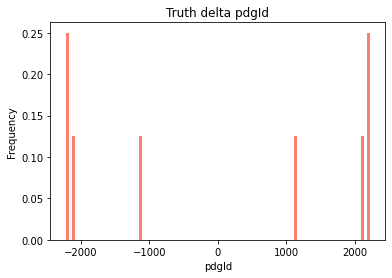

In [175]:
events = ur.open("/fast_scratch_1/atlas_images/MLTree/delta_full_small.root:EventTree")

delta_pdgIds = ak.Array(events["truthPartPdgId"].array())[:, 0]
pu.plot_hist(np.array(delta_pdgIds), 100, "Truth delta pdgId", "pdgId", "Frequency", colour="salmon")

# conversion to arrays takes 

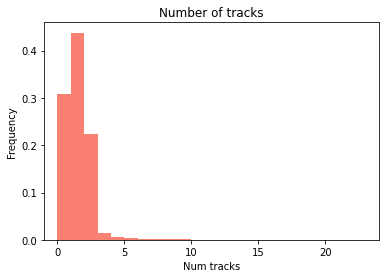

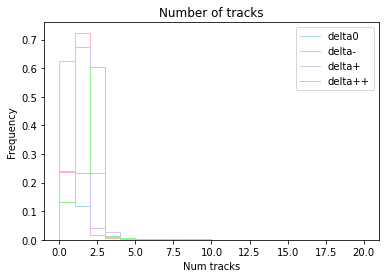

In [176]:
pdgId_dict = {
    2114: "delta0",
    1114: "delta-",
    2214: "delta+",
    2224: "delta++",
}

num_tracks_arr = np.array(events["nTrack"])
pdgIds_arr = np.array(ak.Array(np.array(events["truthPartPdgId"]))[:, 0])
pu.plot_hist(np.array(events["nTrack"]), 20, "Number of tracks", "Num tracks", "Frequency", colour="salmon", xlim=(-1,24))

num_tracks = []
labels = []

for delta_pdgId in pdgId_dict:
    pdgId_cut = (np.abs(pdgIds_arr) == delta_pdgId)
    num_tracks.append(num_tracks_arr[pdgId_cut])
    labels.append(pdgId_dict[delta_pdgId])

    # filter based on pdgId
    """
    pdgId_cut = (pdgIds_arr == delta_pdgId)
    neg_pdgId_cut = (pdgIds_arr == -delta_pdgId)
    num_tracks.append(num_tracks_arr[pdgId_cut])
    num_tracks.append(num_tracks_arr[neg_pdgId_cut])
    labels.append(delta_pdgId)
    labels.append(-1*delta_pdgId)
    """


pu.plot_overlay_hist(num_tracks, 20, "Number of tracks", "Num tracks", "Frequency", labels=labels, colours=pastel_colors)


In [177]:
# for one type of delta event look into the dist between the tracks and charged particles
np.set_printoptions(threshold=sys.maxsize)
abs_pdgId = 2224
delta_pdgIds = ak.Array(np.array(events["truthPartPdgId"]))[:,0]
cut_delta_events_idx = np.arange(len(np.array(events["nTrack"])))[np.abs(delta_pdgIds) == abs_pdgId]


unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in np.array(events["truthPartPdgId"])[cut_delta_events_idx]])
unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
print("num unique lists:", len(unique_pdgIds_lists))

for pdgIds_list in unique_pdgIds_lists:
    print(pdgIds_list)

#print(set(np.array(events["truthPartPdgId"])[cut_delta_events_idx]))
#for event_idx in cut_delta_events_idx:
#    for 



num unique lists: 8
[-2224, -2212, -211, 22, 22, 22]
[-2224, -2212, -211, 22, 22]
[2224, 2212, 211, 22, 22, 22]
[2224, 2212, 211, 22]
[2224, 2212, 211]
[2224, 2212, 211, 22, 22]
[-2224, -2212, -211]
[-2224, -2212, -211, 22]


delta_plus_pi0
frac with this decay: 0.16494
num unique lists: 5
[2214, 2212, 111, 11, 11, 22] num events: 112 - frac of events: 0.014
[2214, 2212, 111, 22, 22, 22, 22] num events: 4 - frac of events: 0.0
[2214, 2212, 111, 22, 22, 22] num events: 234 - frac of events: 0.028
[2214, 2212, 111, 11, 11, 22, 22] num events: 2 - frac of events: 0.0
[2214, 2212, 111, 22, 22] num events: 7895 - frac of events: 0.957



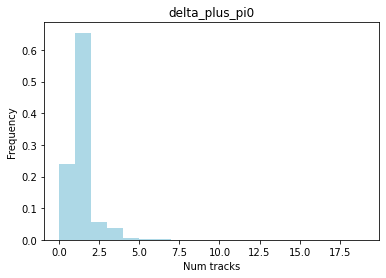

delta_plus_pipm
frac with this decay: 0.08362
num unique lists: 5
[2214, 2112, 211, 22] num events: 497 - frac of events: 0.119
[2214, 2112, 211] num events: 3646 - frac of events: 0.872
[2214, 2112, 211, 22, 22, 22] num events: 3 - frac of events: 0.001
[2214, 2112, 211, 22, 22] num events: 34 - frac of events: 0.008
[2214, 2112, 211, 22, 22, 22, 22] num events: 1 - frac of events: 0.0



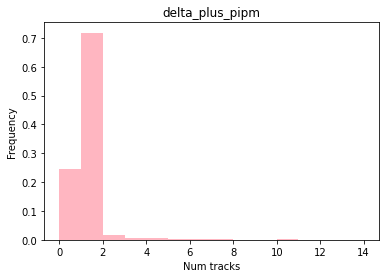

delta_0_pi0_n
frac with this decay: 0.16606
num unique lists: 3
[2114, 2112, 111, 22, 22] num events: 8122 - frac of events: 0.978
[2114, 2112, 111, 11, 11, 22] num events: 99 - frac of events: 0.012
[2114, 2112, 22] num events: 82 - frac of events: 0.01



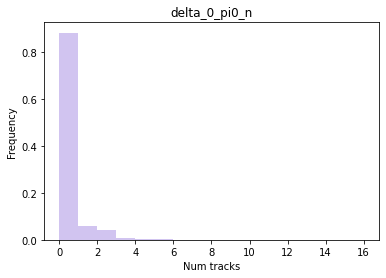

delta_0_pipm_p
frac with this decay: 0.08394
num unique lists: 5
[2114, 2212, 211] num events: 3436 - frac of events: 0.819
[2114, 2212, 211, 22, 22, 22, 22] num events: 2 - frac of events: 0.0
[2114, 2212, 211, 22] num events: 688 - frac of events: 0.164
[2114, 2212, 211, 22, 22] num events: 67 - frac of events: 0.016
[2114, 2212, 211, 22, 22, 22] num events: 4 - frac of events: 0.001



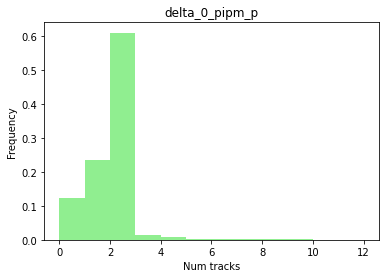

delta_plus_plus
frac with this decay: 0.25
num unique lists: 4
[2224, 2212, 211] num events: 11248 - frac of events: 0.9
[2224, 2212, 211, 22, 22, 22] num events: 3 - frac of events: 0.0
[2224, 2212, 211, 22] num events: 1170 - frac of events: 0.094
[2224, 2212, 211, 22, 22] num events: 79 - frac of events: 0.006



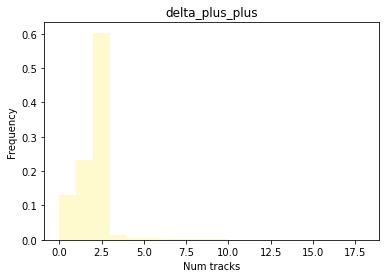

delta_min
frac with this decay: 0.25
num unique lists: 4
[1114, 2112, 211, 22, 22] num events: 98 - frac of events: 0.008
[1114, 2112, 211] num events: 11040 - frac of events: 0.883
[1114, 2112, 211, 22, 22, 22] num events: 3 - frac of events: 0.0
[1114, 2112, 211, 22] num events: 1359 - frac of events: 0.109



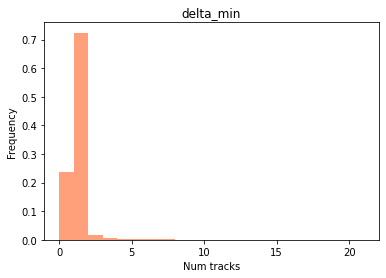

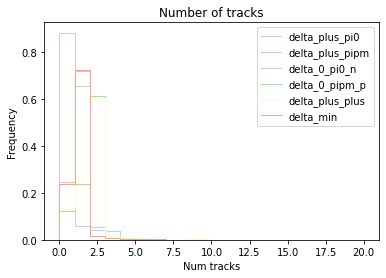

In [178]:
pastel_colors_dict = {
    "delta_plus_pi0": (0.6784, 0.8471, 0.9020),  # Lightblue
    "delta_plus_pipm": (1.0000, 0.7137, 0.7569),  # Lightpink
    "delta_0_pi0_n": (0.8196, 0.7686, 0.9412),  # Lavender
    
    "delta_0_pipm_p": (0.5647, 0.9333, 0.5647),  # Lightgreen
    "delta_plus_plus": (1.0000, 0.9804, 0.8039),  # Lightyellow
    
    "delta_min": (1.0000, 0.6275, 0.4784),  # Lightsalmon
    #(0.8471, 0.7490, 0.8471),  # Thistle
    #(1.0000, 0.8941, 0.8824),  # Mistyrose
    #(1.0000, 0.8549, 0.7255)   # Peachpuff
}


# most of the analysis will be by decay group => get cuts by decay group
truthPartPdgIds = ak.Array(np.abs(events["truthPartPdgId"].array()))
decay_group_cuts = {
    "delta_plus_pi0": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 111),
    "delta_plus_pipm": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 211),
    "delta_0_pi0_n": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2112),
    "delta_0_pipm_p": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2212),
    "delta_plus_plus": (truthPartPdgIds[:, 0] == 2224),
    "delta_min": (truthPartPdgIds[:, 0] == 1114),
}

# get the number of tracks for each decay group
num_tracks = []

for i, decay_cut in enumerate(decay_group_cuts.keys()):
    print(decay_cut)
    print("frac with this decay:", len(truthPartPdgIds[decay_group_cuts[decay_cut]])/len(truthPartPdgIds))

    # get the unique decay sets for the cut
    unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in truthPartPdgIds[decay_group_cuts[decay_cut]]])
    unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
    print("num unique lists:", len(unique_pdgIds_lists))

    for pdgIds_list in unique_pdgIds_lists:
        num_events = np.count_nonzero([(len(cut_pdgIds) == len(pdgIds_list)) and np.all((cut_pdgIds == pdgIds_list)) for cut_pdgIds in truthPartPdgIds[decay_group_cuts[decay_cut]]])
        print(pdgIds_list, "num events:", num_events, "- frac of events:", round(num_events/len(truthPartPdgIds[decay_group_cuts[decay_cut]]), 3))
    print()

    # get the number of tracks for each decay group
    num_tracks_cut = events["nTrack"].array()[decay_group_cuts[decay_cut]]
    num_tracks.append(num_tracks_cut)

    pu.plot_hist(np.array(num_tracks_cut), np.max(num_tracks_cut) + 1, decay_cut, "Num tracks", "Frequency", colour=pastel_colors_dict[decay_cut], discrete=True)

pu.plot_overlay_hist(ak.Array(num_tracks), 20, "Number of tracks", "Num tracks", "Frequency", labels=list(decay_group_cuts.keys()), colours=pastel_colors)



CUT: delta_plus_pi0


ValueError: operands could not be broadcast together with shapes (1,50000) (1,50) 

In [202]:
event_data["cluster_cell_hitsTruthIndex"] = ak.Array(event_data["cluster_cell_hitsTruthIndex"])
event_data["cluster_cell_hitsTruthE"] = ak.Array(event_data["cluster_cell_hitsTruthE"])

truthPartPdgIds = ak.Array(np.abs(event_data["truthPartPdgId"]))

decay_group_cuts = {
    "delta_plus_pi0": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 111),
    "delta_plus_pipm": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 211),
    "delta_0_pi0_n": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2112),
    "delta_0_pipm_p": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2212),
    "delta_plus_plus": (truthPartPdgIds[:, 0] == 2224),
    "delta_min": (truthPartPdgIds[:, 0] == 1114),
}
num_tracks = event_data["nTrack"]

CUT: delta_plus_pi0
frac with 1 track: 0.7
frac dists > 0.1: 0.0


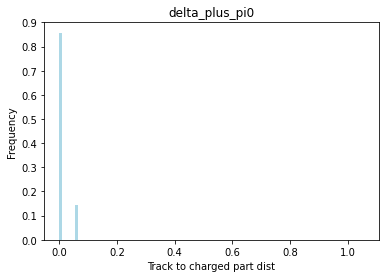

CUT: delta_plus_pipm
frac with 1 track: 0.75
frac dists > 0.1: 0.0


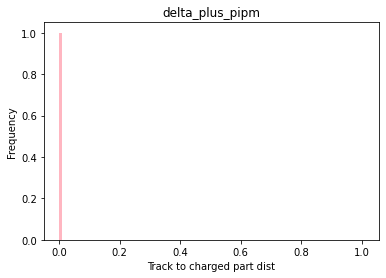

CUT: delta_min
frac with 1 track: 0.727
frac dists > 0.1: 0.0


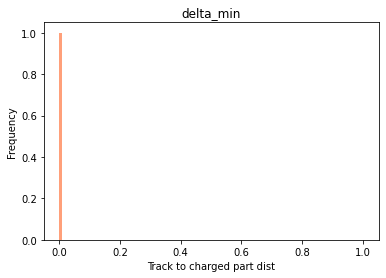

CUT: delta_0_pipm_p
frac with 2 tracks: 0.667
frac dists > 0.1: 0.0


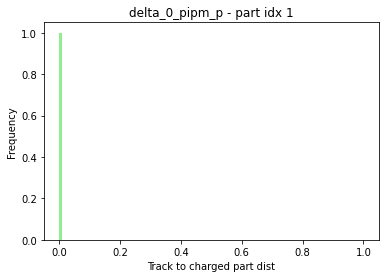

frac dists > 0.1: 0.0


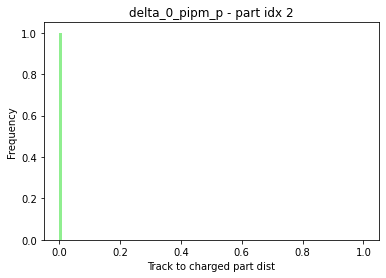

frac dists > 0.1: 0.0


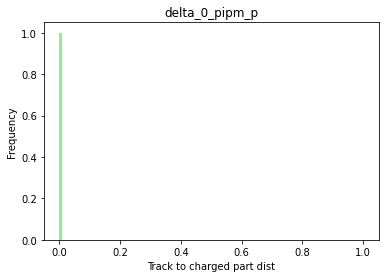

CUT: delta_plus_plus
frac with 2 tracks: 0.615
frac dists > 0.1: 0.0


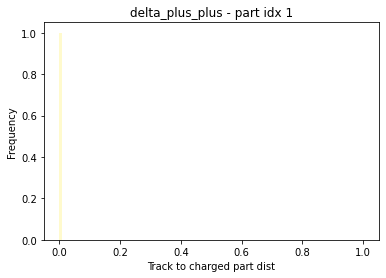

frac dists > 0.1: 0.0


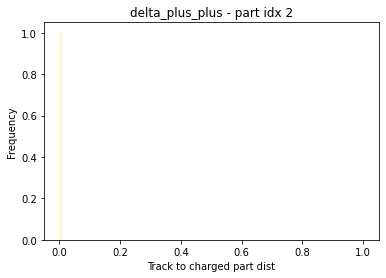

frac dists > 0.1: 0.0


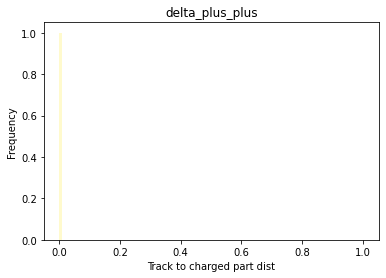

In [186]:
# look into charged particle dist from track for each decay case of delta

def measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p):
    part_vectors = vector.obj(eta=part_eta, phi=part_phi, rho=part_p)
    track_vectors = vector.obj(eta=track_eta, phi=track_phi, rho=track_p)

    return np.array(part_vectors.deltaR(track_vectors))



num_tracks = ak.Array(event_data["nTrack"])

part_phis = ak.Array(event_data["truthPartPhi"])
part_etas = ak.Array(event_data["truthPartEta"])
part_ps = ak.Array(event_data["truthPartPt"])
tracks_phis = ak.Array(event_data["trackPhi"])
tracks_etas = ak.Array(event_data["trackEta"])
tracks_p = ak.Array(event_data["trackPt"])

# one track cases - a) delta_plus_pi0 (delta+ -> pi0 & proton), b) delta+ (delta+ -> pi+/- & neutron), c) delta- (delta- -> pi+/- & neutron -> pi0 -> gammas)
# measure dist between charged particle a) delta_plus_pi0 proton at idx = 1, b) delta_plus_pipm pi+/- at idx = 2, c) delta_min pi+/- at idx = 2 and track
dist_track_part_thresh = 0.1

one_track_cuts_part = {
    "delta_plus_pi0": 1,
    "delta_plus_pipm": 2,
    "delta_min": 2,
}

for cut in one_track_cuts_part.keys():
    print("CUT:", cut)
    event_cut = decay_group_cuts[cut] & (num_tracks == 1)
    print("frac with 1 track:", round(np.count_nonzero(event_cut)/np.count_nonzero(decay_group_cuts[cut]), 3))

    track_phi = tracks_phis[event_cut][:, 0]
    track_eta = tracks_etas[event_cut][:, 0]
    track_p = tracks_p[event_cut][:, 0]

    part_phi = part_phis[event_cut][:, one_track_cuts_part[cut]]
    part_eta = part_etas[event_cut][:, one_track_cuts_part[cut]]
    part_p = part_ps[event_cut][:, one_track_cuts_part[cut]]

    track_dists = measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p)
    print("frac dists > " + str(dist_track_part_thresh) + ":", round(np.count_nonzero(track_dists > dist_track_part_thresh) / len(track_dists), 3))
    pu.plot_hist(np.array(track_dists), 100, cut, "Track to charged part dist", "Frequency", colour=pastel_colors_dict[cut], discrete=True)

# two track cases - a) delta0 -> proton + pi+/- at idx

two_track_cuts_part = {
    "delta_0_pipm_p": [1,2],
    "delta_plus_plus": [1,2],
}
num_part_track_pairs = 2
dist_track_part_thresh = 0.1


for cut in two_track_cuts_part.keys():
    print("CUT:", cut)

    # pair track/part and take the min summed distances? + cut no dist > dist_track_part_thresh
    part_dist_to_tracks = {}
    event_cut = decay_group_cuts[cut] & (num_tracks == 2)
    num_events_in_cut = np.count_nonzero(event_cut)
    print("frac with 2 tracks:" , round(num_events_in_cut/np.count_nonzero(decay_group_cuts[cut]), 3))
    
    for part_idx in two_track_cuts_part[cut]:
        part_dist_to_tracks[part_idx] = []
        for track_idx in range(2):
            track_phi = tracks_phis[event_cut][:, track_idx]
            track_eta = tracks_etas[event_cut][:, track_idx]
            track_p = tracks_p[event_cut][:, track_idx]

            part_phi = part_phis[event_cut][:, part_idx]
            part_eta = part_etas[event_cut][:, part_idx]
            part_p = part_ps[event_cut][:, part_idx]

            # if the dist exceeds the threshold - set equal to num_pairs*threshold so it exceeds the summed threshold
            track_dists = measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p)
            track_dists[track_dists > dist_track_part_thresh] = num_part_track_pairs*dist_track_part_thresh

            part_dist_to_tracks[part_idx].append(track_dists)
    
    # compute summed dists for potential track/particle pairings (only 2 for now)
    summed_dist_pairing_1 = part_dist_to_tracks[1][0] + part_dist_to_tracks[2][1]
    summed_dist_pairing_2 = part_dist_to_tracks[1][1] + part_dist_to_tracks[2][0]

    min_pair_idx = np.argmin([summed_dist_pairing_1, summed_dist_pairing_2], axis=0) # 0 => pair part 1 with track 0, 1 => pair part 1 with track 1

    part_1_to_paired_track_dist = np.zeros(num_events_in_cut)
    # if min pair idx == 0 => pair part idx 1 with track 0, else pair part idx 1 with track 0
    part_1_to_paired_track_dist[min_pair_idx == 0] = part_dist_to_tracks[1][0][min_pair_idx == 0]
    part_1_to_paired_track_dist[min_pair_idx == 1] = part_dist_to_tracks[1][1][min_pair_idx == 1]
    print("frac dists > " + str(dist_track_part_thresh) + ":", round(np.count_nonzero(part_1_to_paired_track_dist > dist_track_part_thresh) / len(part_1_to_paired_track_dist), 3))
    pu.plot_hist(part_1_to_paired_track_dist, 100, cut + " - part idx 1", "Track to charged part dist", "Frequency", colour=pastel_colors_dict[cut], discrete=True)

    part_2_to_paired_track_dist = np.zeros(num_events_in_cut)
    # if min pair idx == 0 => pair part idx 2 with track 1, else pair part idx 2 with track 1
    part_2_to_paired_track_dist[min_pair_idx == 0] = part_dist_to_tracks[2][1][min_pair_idx == 0]
    part_2_to_paired_track_dist[min_pair_idx == 1] = part_dist_to_tracks[2][0][min_pair_idx == 1]
    print("frac dists > " + str(dist_track_part_thresh) + ":", round(np.count_nonzero(part_2_to_paired_track_dist > dist_track_part_thresh) / len(part_2_to_paired_track_dist), 3))
    pu.plot_hist(part_2_to_paired_track_dist, 100, cut + " - part idx 2", "Track to charged part dist", "Frequency", colour=pastel_colors_dict[cut], discrete=True)

    
    # plot together to rep full cut
    part_to_paired_track_sum_min_dist = part_1_to_paired_track_dist + part_2_to_paired_track_dist
    print("frac dists > " + str(dist_track_part_thresh) + ":", round(np.count_nonzero(part_to_paired_track_sum_min_dist > num_part_track_pairs*dist_track_part_thresh) / len(part_to_paired_track_sum_min_dist), 3))
    pu.plot_hist(part_to_paired_track_sum_min_dist, 100, cut, "Track to charged part dist", "Frequency", colour=pastel_colors_dict[cut], discrete=True)


NO TRACKS: Delta0 -> pi0 + neutron analysis

0.153
num unique lists: 2
[2114, 2112, 111, 22, 22] num events: 151 - frac of events: 0.987
[2114, 2112, 22] num events: 2 - frac of events: 0.013
[1, 4, 3, 1, 3, 1, 4, 3, 1, 4, 3, 4, 3, 4, 1, 3, 4, 3, 4, 3, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 4, 3, 1, 4, 3, 1, 4, 3, 4, 3, 3, 1, 4, 3, 1, 4, 3, 3, 4, 3, 1, 4, 3, 3, 4, 3, 3, 4, 3, 1, 3, 4, 3, 4, 1, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 4, 3, 1, 4, 3, 3, 1, 1, 4, 3, 1, 4, 3, 1, 3, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 4, 3, 3, 1, 4, 3, 4, 3, 3, 4, 1, 3, 4, 1, 3, 4, 1, 3, 4, 3, 1, 4, 3, 4, 3, 4, 3, 1, 4, 3, 1, 4, 1, 3, 1, 3, 4, 1, 3, 4, 1, 3, 1, 4, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 4, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 4, 3, 4, 1, 3, 4, 1, 3, 1, 3, 3, 1, 4, 1, 3, 4, 1, 3, 4, 1, 3, 1, 4, 3, 1, 4, 3, 4, 1, 3, 4, 1, 3, 4, 3, 1, 4, 3, 1, 3, 1, 1, 3, 4, 3, 1, 4, 3, 1, 4, 1, 3, 4, 1, 3, 1, 4, 3, 4, 1, 3, 4, 1, 3, 4, 1, 3, 4, 1, 3, 4, 1, 3, 4, 3, 1, 4, 1, 3, 1, 4, 3, 4, 1, 3, 4, 1, 3, 1, 

/tmp/ipykernel_13687/1117094012.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])


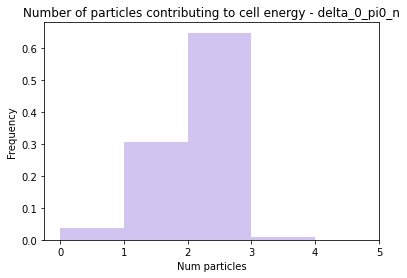

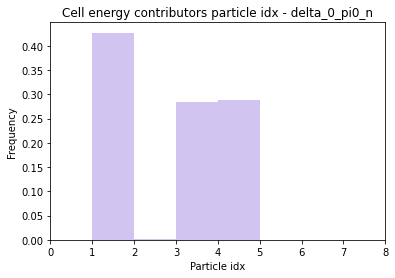

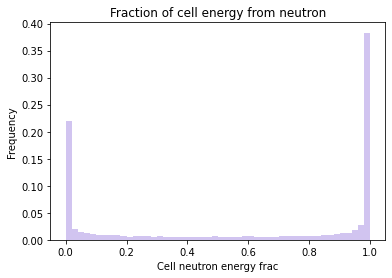

frac with 1 part contr: 0.44354660661456263
frac with close to 1 part contr: 0.7039784518920829


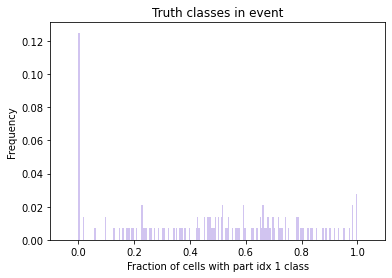

4


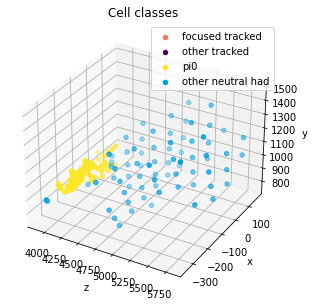

13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


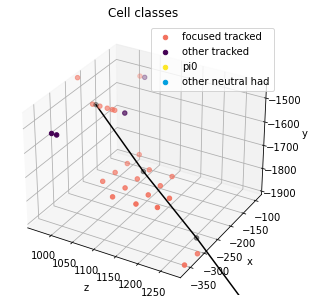

15
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


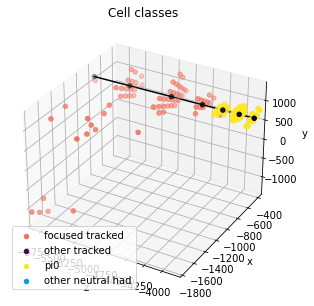

17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


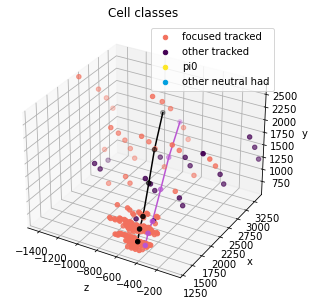

31
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


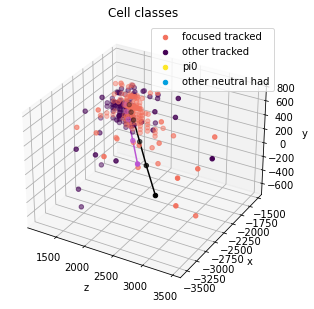

38
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


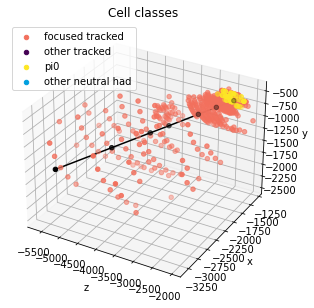

41
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


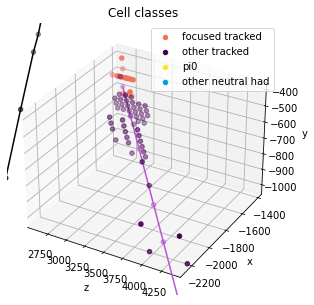

42
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


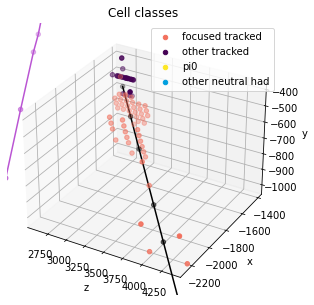

47


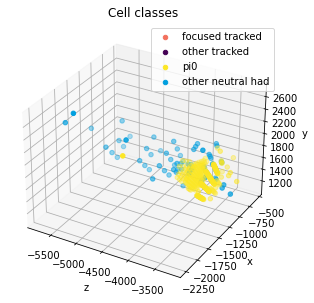

54
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


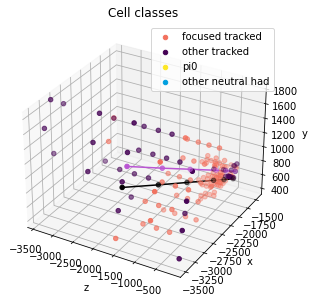

In [203]:
# delta_0_pi0_n
# **use events_data - all events with the clus flattened but clus structure info added
cut = "delta_0_pi0_n"
event_cut = decay_group_cuts[cut] & (num_tracks == 0)
events_idx = np.arange(len(event_data["nTrack"]))[event_cut]
print(np.count_nonzero(event_cut)/len(event_cut))

# get the unique decay sets for the cut
unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in truthPartPdgIds[event_cut]])
unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
print("num unique lists:", len(unique_pdgIds_lists))

for pdgIds_list in unique_pdgIds_lists:
    num_events = np.count_nonzero([(len(cut_pdgIds) == len(pdgIds_list)) and np.all((cut_pdgIds == pdgIds_list)) for cut_pdgIds in truthPartPdgIds[event_cut]])
    print(pdgIds_list, "num events:", num_events, "- frac of events:", round(num_events/len(truthPartPdgIds[event_cut]), 3))

# look into which particles are depositing energy (should only be pi0 or neutron or gamma? - AHH is the gamma associated with the pi0 or neutron???) 
np.set_printoptions(threshold=sys.maxsize)

print(flatten_layers(event_data["cluster_cell_hitsTruthIndex"][event_cut], 2))
print(flatten_layers(event_data["cluster_cell_hitsTruthE"][event_cut], 2))

print(event_data["truthPartPdgId"][event_cut][:2])
print(event_data["truthPartE"][event_cut][:2])

# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 4, "Number of particles contributing to cell energy - " + cut, "Num particles", "Frequency", xlim=(-0.25, 5), colour=pastel_colors_dict[cut], discrete=True)

# which particles are contributing
cell_energy_contr_part_idx = np.array(flatten_layers(event_data["cluster_cell_hitsTruthIndex"][event_cut], 2))
pu.plot_hist(cell_energy_contr_part_idx, 4, "Cell energy contributors particle idx - " + cut, "Particle idx", "Frequency", colour=pastel_colors_dict[cut], xlim=(0,8), discrete=True) 

# fraction of energy contributed by particle idx 1 == neutron
cut_part_idx_1_deposits = (event_data["cluster_cell_hitsTruthIndex"][event_cut] == 1)

frac_cell_energy_from_part_idx_1 = ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut][cut_part_idx_1_deposits], axis=2) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut], axis=2)
frac_cell_energy_from_part_idx_1_flat = np.array(flatten_one_layer(frac_cell_energy_from_part_idx_1))
pu.plot_hist(np.array(frac_cell_energy_from_part_idx_1_flat), 50, "Fraction of cell energy from neutron", "Cell neutron energy frac", "Frequency", colour=pastel_colors_dict[cut])

print("frac with 1 part contr:", np.count_nonzero((frac_cell_energy_from_part_idx_1_flat == 0) | (frac_cell_energy_from_part_idx_1_flat == 1))/len(frac_cell_energy_from_part_idx_1_flat))
print("frac with close to 1 part contr:", np.count_nonzero((frac_cell_energy_from_part_idx_1_flat < 0.1) | (frac_cell_energy_from_part_idx_1_flat > 0.9))/len(frac_cell_energy_from_part_idx_1_flat))

frac_cells_part_idx_1_energy_class_per_event = [np.nan if len(event_frac_cell_energy_from_part_idx_1) == 0 else np.count_nonzero(event_frac_cell_energy_from_part_idx_1 > 0.5)/len(event_frac_cell_energy_from_part_idx_1) for event_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
pu.plot_hist(frac_cells_part_idx_1_energy_class_per_event, 200, "Truth classes in event", "Fraction of cells with part idx 1 class", "Frequency", True, pastel_colors_dict[cut], (-0.1,1.1)) # #009fdf


# use processed event data to plot event displays
for cut_event_idx, event_idx in enumerate(events_idx[:10]):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx]
    z = processed_event_data["z"][event_idx]

    cell_labels = [2 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else 3 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1[cut_event_idx]]
    plot_proccessed_cells_in_line([x], [y], [z], [processed_event_data["cell_labels"][event_idx]], ["Cell classes"], "z", "x", "y", [None], [None], event_idx, add_track=True)


ONE TRACK: Delta- -> neutron + pi+/-, Delta+ -> neutron + pi+/-, Delta- -> proton + pi0

0.14
num unique lists: 1
[2214, 2212, 111, 22, 22] num events: 7 - frac of events: 1.0


/tmp/ipykernel_13687/2427930352.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])


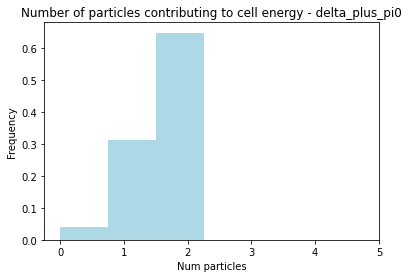

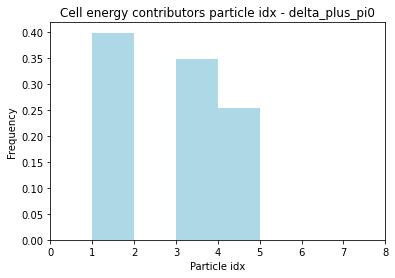

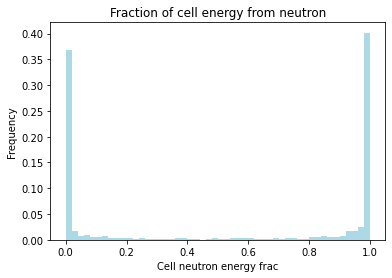

frac with 1 part contr: 0.556316590563166
frac with close to 1 part contr: 0.8257229832572298


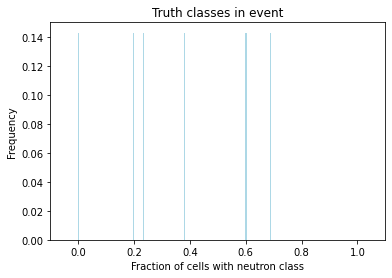

IndexError: boolean index did not match indexed array along dimension 0; dimension is 241 but corresponding boolean dimension is 5

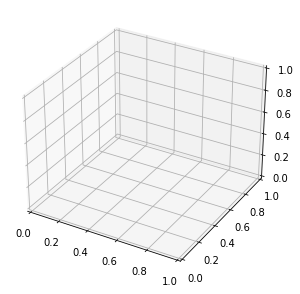

In [192]:
# delta_min, delta_plus_pipm, delta_plus_pi0
# **use events_data - all events with the clus flattened but clus structure info added
cut = "delta_plus_pi0"
event_cut = decay_group_cuts[cut] & (num_tracks == 1)
events_idx = np.arange(len(event_data["nTrack"]))[event_cut]
print(np.count_nonzero(event_cut)/len(event_cut))

# get the unique decay sets for the cut
unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in truthPartPdgIds[event_cut]])
unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
print("num unique lists:", len(unique_pdgIds_lists))

for pdgIds_list in unique_pdgIds_lists:
    num_events = np.count_nonzero([(len(cut_pdgIds) == len(pdgIds_list)) and np.all((cut_pdgIds == pdgIds_list)) for cut_pdgIds in truthPartPdgIds[event_cut]])
    print(pdgIds_list, "num events:", num_events, "- frac of events:", round(num_events/len(truthPartPdgIds[event_cut]), 3))

# look into which particles are depositing energy (should only be pi0 or neutron or gamma? - AHH is the gamma associated with the pi0 or neutron???) 
np.set_printoptions(threshold=sys.maxsize)

# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 4, "Number of particles contributing to cell energy - " + cut, "Num particles", "Frequency", xlim=(-0.25, 5), colour=pastel_colors_dict[cut], discrete=True)

# which particles are contributing
cell_energy_contr_part_idx = np.array(flatten_layers(event_data["cluster_cell_hitsTruthIndex"][event_cut], 2))
pu.plot_hist(cell_energy_contr_part_idx, np.max(cell_energy_contr_part_idx) - np.min(cell_energy_contr_part_idx) + 1, "Cell energy contributors particle idx - " + cut, "Particle idx", "Frequency", colour=pastel_colors_dict[cut], xlim=(0,8), discrete=True) 

# fraction of energy contributed by neutrons
cut_neutron_deposits = (event_data["cluster_cell_hitsTruthIndex"][event_cut] == 1)

frac_cell_energy_from_neutron = ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut][cut_neutron_deposits], axis=2) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut], axis=2)
frac_cell_energy_from_neutron_flat = np.array(flatten_one_layer(frac_cell_energy_from_neutron))
pu.plot_hist(np.array(frac_cell_energy_from_neutron_flat), 50, "Fraction of cell energy from neutron", "Cell neutron energy frac", "Frequency", colour=pastel_colors_dict[cut])

print("frac with 1 part contr:", np.count_nonzero((frac_cell_energy_from_neutron_flat == 0) | (frac_cell_energy_from_neutron_flat == 1))/len(frac_cell_energy_from_neutron_flat))
print("frac with close to 1 part contr:", np.count_nonzero((frac_cell_energy_from_neutron_flat < 0.1) | (frac_cell_energy_from_neutron_flat > 0.9))/len(frac_cell_energy_from_neutron_flat))

frac_cells_neutron_class_per_event = np.array([np.nan if len(event_frac_cell_energy_from_neutron) == 0 else np.count_nonzero(event_frac_cell_energy_from_neutron > 0.5)/len(event_frac_cell_energy_from_neutron) for event_frac_cell_energy_from_neutron in frac_cell_energy_from_neutron])
pu.plot_hist(frac_cells_neutron_class_per_event[~np.isnan(frac_cells_neutron_class_per_event)], 200, "Truth classes in event", "Fraction of cells with neutron class", "Frequency", True, pastel_colors_dict[cut], (-0.1,1.1)) # #009fdf

for cut_event_idx, event_idx in enumerate(events_idx[:10]):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx]
    z = processed_event_data["z"][event_idx]

    if len(x):
        cell_labels = [2 if cell_frac_cell_energy_from_neutron < 0.5 else 0 for cell_frac_cell_energy_from_neutron in frac_cell_energy_from_neutron[cut_event_idx]]
        plot_proccessed_cells_in_line([x], [y], [z], [cell_labels], ["Cell classes"], "z", "x", "y", [None], [None], event_idx, add_track=True)


In [193]:
for event_idx in range(100): 
    if len(event_data["truthPartPdgId"][event_cut][event_idx]) == 4:
        print(event_data["truthPartPdgId"][event_cut][event_idx])
        print(event_data["truthPartE"][event_cut][event_idx])
        print()

frac_contr_by_gammas = np.array([np.sum(event_truthPartE[3:])/event_truthPartE[0] if len(event_truthPartE) > 3 else np.nan for event_truthPartE in event_data["truthPartE"][event_cut]])
print(event_data["truthPartPdgId"][event_cut][frac_contr_by_gammas > 0.1])
print(event_data["truthPartE"][event_cut][frac_contr_by_gammas > 0.1])

pu.plot_hist(frac_contr_by_gammas[~np.isnan(frac_contr_by_gammas)], 200, "Fraction event energy from gammas", "Gammas energy frac", "Frequency", True, pastel_colors_dict[cut])


ValueError: in ListArray64 attempting to get 7, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/ListArray.cpp#L668)

2 TRACKS: Delta0 -> pi+/- + proton, Delta++ -> pi+/- + proton

0.04
num unique lists: 1
[2114, 2212, 211] num events: 2 - frac of events: 1.0


/tmp/ipykernel_13687/1006616102.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])


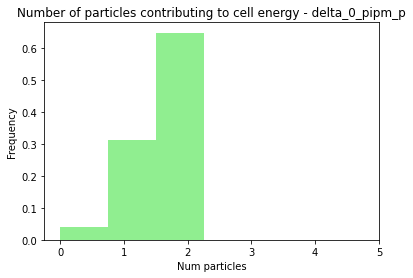

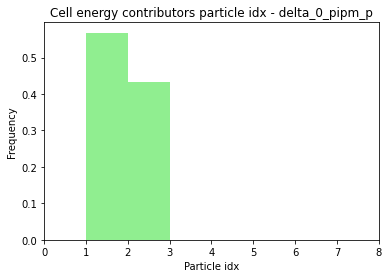

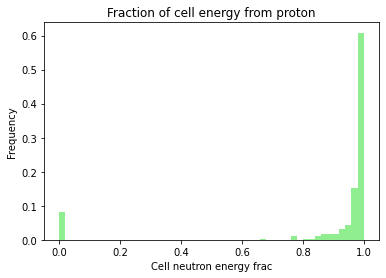

frac with 1 part contr: 0.3783783783783784
frac with close to 1 part contr: 0.918918918918919


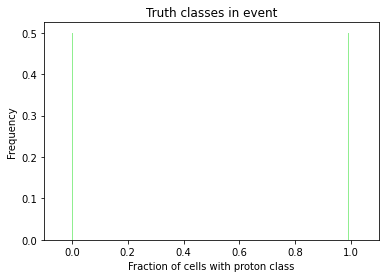

IndexError: boolean index did not match indexed array along dimension 0; dimension is 140 but corresponding boolean dimension is 269

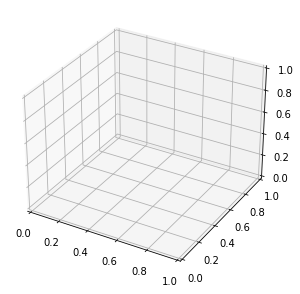

In [194]:
# **use events_data - all events with the clus flattened but clus structure info added
cut = "delta_0_pipm_p"
event_cut = decay_group_cuts[cut] & (num_tracks == 2)
events_idx = np.arange(len(event_data["nTrack"]))[event_cut]
print(np.count_nonzero(event_cut)/len(event_cut))

# get the unique decay sets for the cut
unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in truthPartPdgIds[event_cut]])
unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
print("num unique lists:", len(unique_pdgIds_lists))

for pdgIds_list in unique_pdgIds_lists:
    num_events = np.count_nonzero([(len(cut_pdgIds) == len(pdgIds_list)) and np.all((cut_pdgIds == pdgIds_list)) for cut_pdgIds in truthPartPdgIds[event_cut]])
    print(pdgIds_list, "num events:", num_events, "- frac of events:", round(num_events/len(truthPartPdgIds[event_cut]), 3))

# look into which particles are depositing energy (should only be pi0 or neutron or gamma? - AHH is the gamma associated with the pi0 or neutron???) 
np.set_printoptions(threshold=sys.maxsize)

# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in ak.Array(event_data["cluster_cell_hitsTruthIndex"])[decay_group_cuts[decay_cut]]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 4, "Number of particles contributing to cell energy - " + cut, "Num particles", "Frequency", xlim=(-0.25, 5), colour=pastel_colors_dict[cut], discrete=True)

# which particles are contributing
cell_energy_contr_part_idx = np.array(flatten_layers(event_data["cluster_cell_hitsTruthIndex"][event_cut], 2))
pu.plot_hist(cell_energy_contr_part_idx, np.max(cell_energy_contr_part_idx) - np.min(cell_energy_contr_part_idx) + 1, "Cell energy contributors particle idx - " + cut, "Particle idx", "Frequency", colour=pastel_colors_dict[cut], xlim=(0,8), discrete=True) 

# fraction of energy contributed by neutrons
cut_neutron_deposits = (event_data["cluster_cell_hitsTruthIndex"][event_cut] == 1)

frac_cell_energy_from_neutron = ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut][cut_neutron_deposits], axis=2) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_cut], axis=2)
frac_cell_energy_from_neutron_flat = np.array(flatten_one_layer(frac_cell_energy_from_neutron))
pu.plot_hist(frac_cell_energy_from_neutron_flat[~np.isnan(frac_cell_energy_from_neutron_flat)], 50, "Fraction of cell energy from proton", "Cell neutron energy frac", "Frequency", colour=pastel_colors_dict[cut])

print("frac with 1 part contr:", np.count_nonzero((frac_cell_energy_from_neutron_flat == 0) | (frac_cell_energy_from_neutron_flat == 1))/len(frac_cell_energy_from_neutron_flat))
print("frac with close to 1 part contr:", np.count_nonzero((frac_cell_energy_from_neutron_flat < 0.1) | (frac_cell_energy_from_neutron_flat > 0.9))/len(frac_cell_energy_from_neutron_flat))

frac_cells_neutron_class_per_event = np.array([np.nan if len(event_frac_cell_energy_from_neutron) == 0 else np.count_nonzero(event_frac_cell_energy_from_neutron > 0.5)/len(event_frac_cell_energy_from_neutron) for event_frac_cell_energy_from_neutron in frac_cell_energy_from_neutron])
pu.plot_hist(frac_cells_neutron_class_per_event[~np.isnan(frac_cells_neutron_class_per_event)], 200, "Truth classes in event", "Fraction of cells with proton class", "Frequency", True, pastel_colors_dict[cut], (-0.1,1.1)) # #009fdf

for cut_event_idx, event_idx in enumerate(events_idx[:10]):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx]
    z = processed_event_data["z"][event_idx]

    if len(x):
        # match the track and charged particle (min_pair_idx == 0 => match proton with track 1, 2 => match proton with track 2)
        cell_labels = [1 if cell_frac_cell_energy_from_neutron < 0.5 else 0 for event_idx, cell_frac_cell_energy_from_neutron in enumerate(frac_cell_energy_from_neutron[cut_event_idx])]
        
        plot_proccessed_cells_in_line([x], [y], [z], [cell_labels], ["Cell classes"], "z", "x", "y", [None], [None], event_idx, add_track=True)


decay group: 5.0
0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


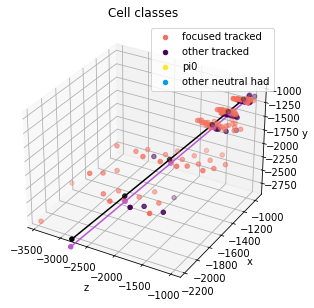

decay group: 5.0
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


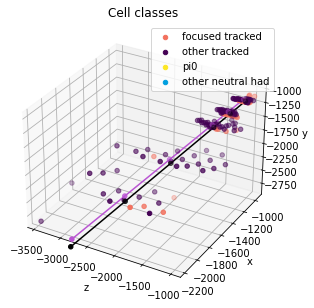

decay group: 1.0
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


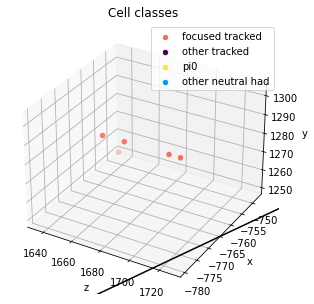

decay group: 6.0
3
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


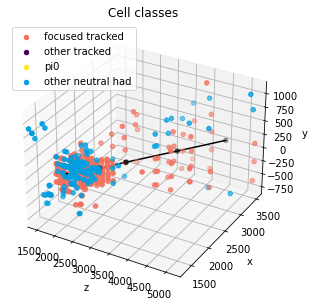

decay group: 3.0
4


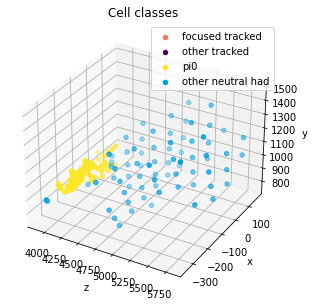

decay group: 3.0
5


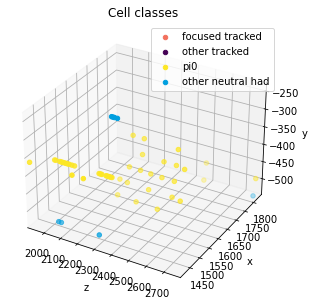

decay group: 4.0
6
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


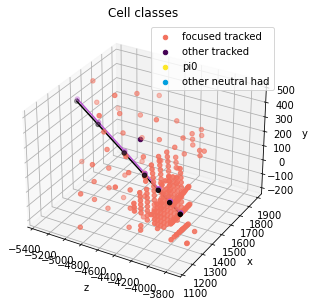

decay group: 4.0
7
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


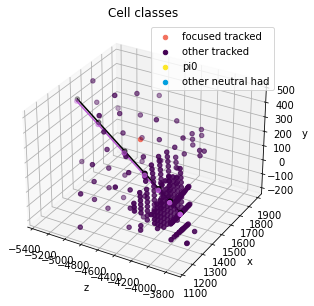

decay group: 6.0
8
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


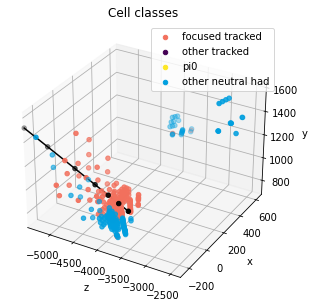

decay group: 5.0
9
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


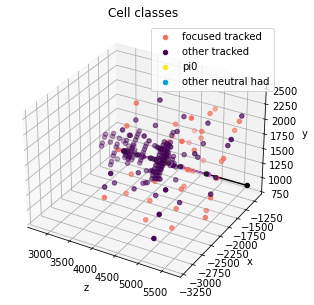

decay group: 5.0
10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


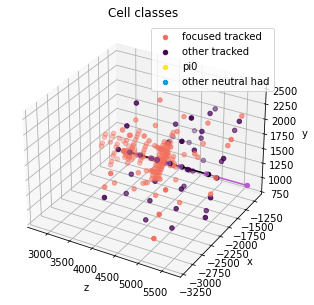

decay group: 1.0
11
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


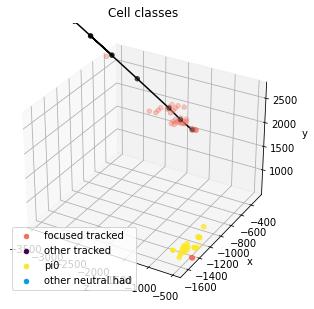

decay group: 4.0
12
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


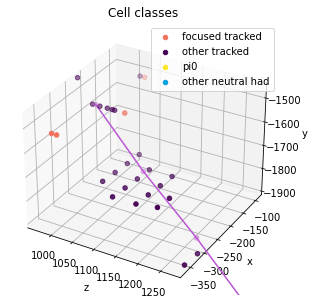

decay group: 4.0
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


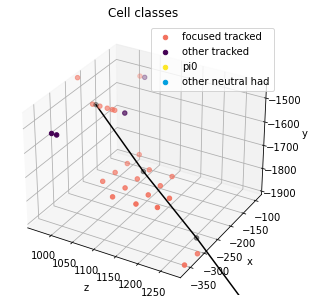

decay group: 1.0
14
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


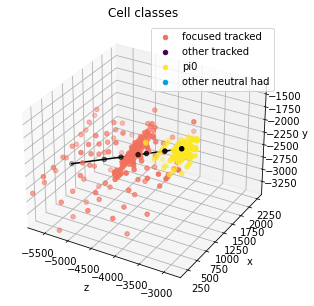

decay group: 1.0
15
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


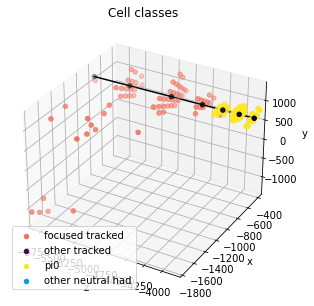

decay group: 5.0
16
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


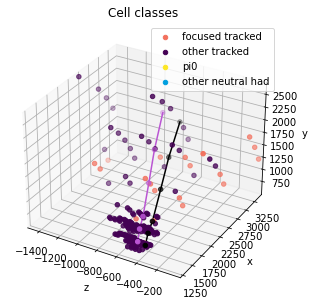

decay group: 5.0
17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


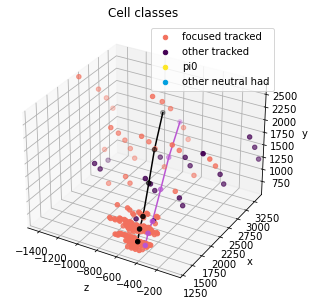

decay group: 3.0
18


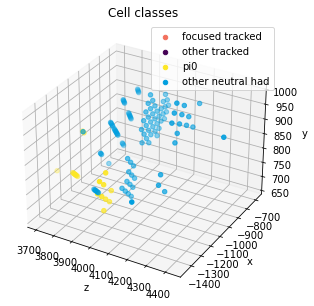

decay group: 5.0
19
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


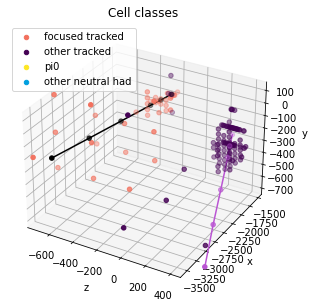

decay group: 5.0
20
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


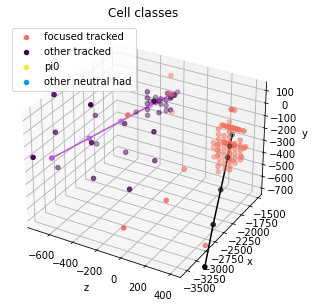

decay group: 3.0
21


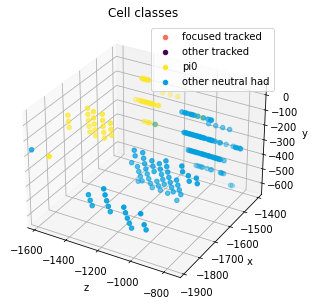

decay group: 5.0
22
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


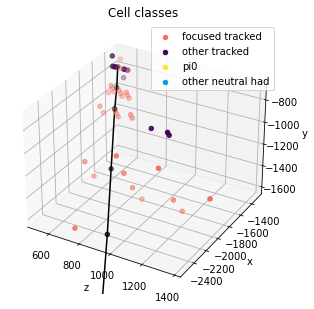

decay group: 5.0
23
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


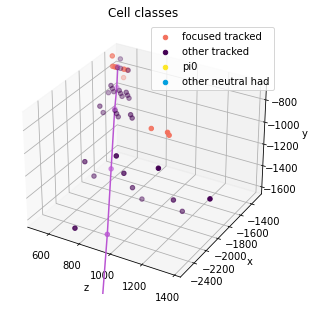

decay group: 3.0
24


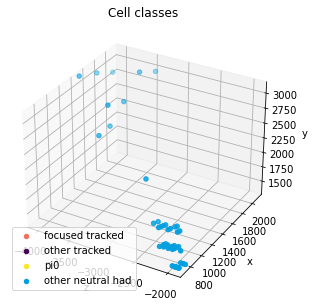

decay group: 6.0
25
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


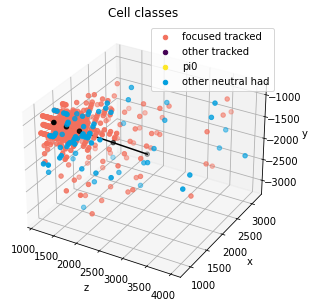

decay group: 1.0
26
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


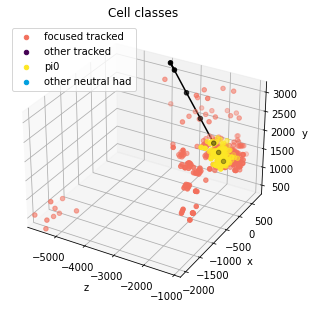

IndexError: list index out of range

In [ ]:
for event_idx in range(50):
    print("decay group:", processed_event_data["decay_group"][event_idx])
    plot_proccessed_cells_in_line([processed_event_data["x"][event_idx]], [processed_event_data["y"][event_idx]], [processed_event_data["z"][event_idx]], [processed_event_data["cell_labels"][event_idx]], ["Cell classes"], "z", "x", "y", [None], [None], event_idx, add_track=True)